In [11]:
import pandas as pd
import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from lempel_ziv_complexity import lempel_ziv_complexity

In [12]:
df = pd.read_csv("filled/transact_18_22.csv")
df.set_index(['client', 'date'], inplace=True)
df.index = df.index.set_levels(pd.to_datetime(df.index.levels[1]), level=1)
df = df.sort_index()
df

survival  socialization  self_realization  code
client  date                                                       
224     2019-01-03       1.0            0.0               0.0   1.0
        2019-01-04       0.0            0.0               0.0   0.0
        2019-01-05       1.0            0.0               0.0   1.0
        2019-01-06       1.0            1.0               0.0   3.0
        2019-01-07       1.0            0.0               0.0   1.0
...                      ...            ...               ...   ...
3564569 2019-12-10       1.0            0.0               0.0   1.0
        2019-12-11       1.0            0.0               0.0   1.0
        2019-12-12       1.0            0.0               0.0   1.0
        2019-12-13       1.0            0.0               0.0   1.0
        2019-12-14       1.0            0.0               0.0   1.0

[2760863 rows x 4 columns]

In [13]:
def compute_normalized_lzc(df: pd.DataFrame, columns: list):
    clients = df.index.get_level_values(0).unique()
    result = []

    for client in tqdm(clients, desc="Processing clients"):
        client_data = df.xs(client, level=0)
        client_row = {}

        for col in columns:
            s = ''.join(client_data[col].astype(str).tolist())
            lzc = lempel_ziv_complexity(s)
            n = len(s)
            lzc_norm = lzc / (n / np.log2(n))

            client_row[f'{col}'] = lzc_norm

        result.append(pd.Series(client_row, name=client))

    df_result = pd.DataFrame(result)
    df_result.index.name = 'client'

    return df_result


In [14]:
one_dimensional_lzc = compute_normalized_lzc(df, ["survival", "socialization", "self_realization"])
one_dimensional_lzc

Processing clients: 100%|██████████| 8034/8034 [00:09<00:00, 867.17it/s]


,survival,socialization,self_realization
client,,,
224,1.303126,0.839792,0.859098
1117,1.170884,0.851552,0.764462
1197,1.074117,0.822522,0.996703
1223,1.157275,0.884975,0.816900
1555,1.280653,0.808833,0.876236
...,...,...,...
3560436,1.159127,0.913549,0.874257
3561841,1.206598,0.917015,0.820487
3561945,1.180561,0.880582,0.754785


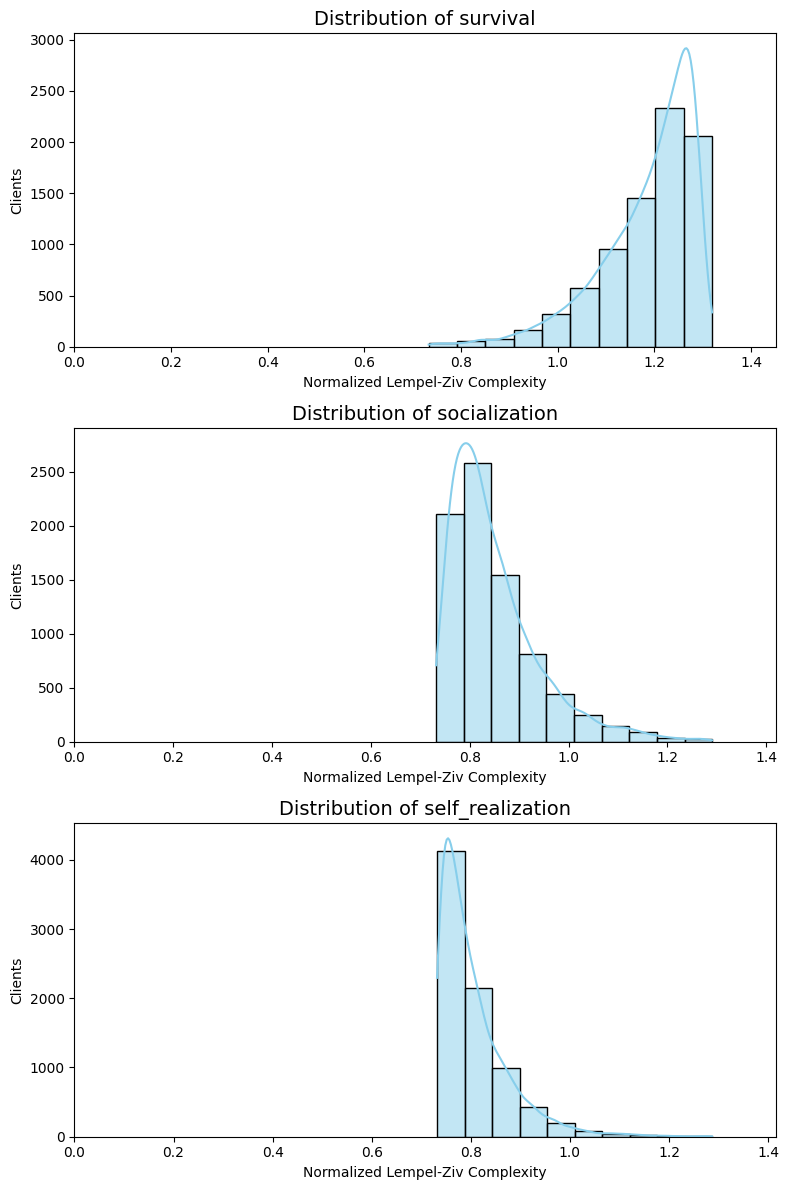

In [15]:
def plot_lzc_distributions(df_lzc):
    num_cols = len(df_lzc.columns)
    fig, axes = plt.subplots(num_cols, 1, figsize=(8, 4*num_cols))

    if num_cols == 1:
        axes = [axes]

    for ax, col in zip(axes, df_lzc.columns):
        sns.histplot(df_lzc[col], bins=10, kde=True, ax=ax, color='skyblue')
        ax.set_title(f'Distribution of {col}', fontsize=14)
        ax.set_xlabel('Normalized Lempel-Ziv Complexity')
        ax.set_ylabel('Clients')
        ax.set_xlim(0, df_lzc[col].max()*1.1)

    plt.tight_layout()
    plt.show()


plot_lzc_distributions(one_dimensional_lzc)